# MDP Algorithms with OpenAI Gym

In [190]:
import numpy as np
import gym
import gym.spaces as spaces
import time

import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

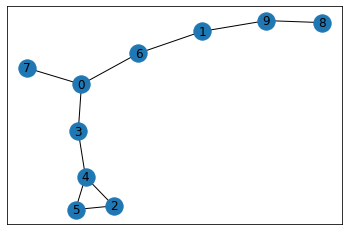

In [232]:
# Number of locations in the city
N = 10
connectivity = 2
p = 0.8

# make a random graph to represent a city network
road_network = nx.connected_watts_strogatz_graph(N, connectivity, p)
nodes = road_network.nodes

nx.draw_networkx(road_network)
plt.show()

In [233]:
class Taxi:
    """
    A taxi class to keep track of the internal state for each taxi.
    """
    def __init__(self, number, start_location):
        self._number = number
        self.available = True
        self.current_location = start_location

        self.source = []
        self.destination = []
        self.path = []
        self.path_generator = None
        self.expected_reward = 0.
        self.customer_wait_time = None

    @property
    def number(self):
        return self._number

    def hire(self, source, destination):
        if self.available == True:
            self.available = False
            self.source = source
            self.destination = destination

            self.set_path_and_reward(source, destination)
            
    def dispatch(self, destination):
        self.destination = destination
        to_destination = nx.shortest_path(road_network, self.current_location,
                                       destination)
        self.path = to_destination
        self.path_generator = (p for p in self.path)
        
        cost = len(to_destination) - 1
        self.expected_reward = -cost

            
    def set_path_and_reward(self, source, destination):
        """
        Sets a path from current location to source and then the destination.
        """
        to_customer = nx.shortest_path(road_network, self.current_location,
                                       source)
        to_destination = nx.shortest_path(road_network, source,
                                       destination)
        
        total_path = to_customer[:-1]+to_destination
        self.path = total_path
        self.path_generator = (p for p in self.path)
        
        cost_to_go_to_customer = len(to_customer) - 1
        trip_reward = 3*(len(to_destination) - 1)

        self.expected_reward += trip_reward - cost_to_go_to_customer
        self.customer_wait_time = len(to_customer) - 1


    def reset(self):
        self.available = True
        
        self.source = []
        self.destination = []
        self.path = []
        self.path_generator = None
        self.expected_reward = 0.


    def step(self):
        if (self.current_location == self.destination) and (self.available == True):
            self.reset()
        else:
            try:
                self.current_location = next(self.path_generator)
            except:
                pass
    
    def __repr__(self):
        return str(self.number)

# Set taxi at location 5
taxi_test = Taxi(0, 2)

# Hire for a delivery from location
taxi_test.hire(0, 5)

print("Total path to travel", taxi_test.path)
print("Total expected reward", taxi_test.expected_reward)
print("Total customer wait time", taxi_test.customer_wait_time)

# Take a few steps
for i in range(10):
    taxi_test.step()
    print("Location: ", taxi_test.current_location)

Total path to travel [2, 4, 3, 0, 3, 4, 5]
Total expected reward 6.0
Total customer wait time 3
Location:  2
Location:  4
Location:  3
Location:  0
Location:  3
Location:  4
Location:  5
Location:  5
Location:  5
Location:  5


In [234]:
# Set taxi at location 5
taxi_test = Taxi(0, 1)

# Hire for a delivery from location
taxi_test.dispatch(6)

print("Total path to travel", taxi_test.path)
print("Total expected reward", taxi_test.expected_reward)
print("Total customer wait time", taxi_test.customer_wait_time)

# Take a few steps
for i in range(10):
    taxi_test.step()
    print("Location: ", taxi_test.current_location)
    print("Total expected reward", taxi_test.expected_reward)

Total path to travel [1, 6]
Total expected reward -1
Total customer wait time None
Location:  1
Total expected reward -1
Location:  6
Total expected reward -1
Location:  6
Total expected reward 0.0
Location:  6
Total expected reward 0.0
Location:  6
Total expected reward 0.0
Location:  6
Total expected reward 0.0
Location:  6
Total expected reward 0.0
Location:  6
Total expected reward 0.0
Location:  6
Total expected reward 0.0
Location:  6
Total expected reward 0.0


In [235]:
taxi_test.expected_reward

0.0

In [305]:
class Environment(object):
    def __init__(self, road_network, num_taxis):
        """
        An environment to play the game
        
        Args:
            road_network (`nx.Graph`): a networkX graph representing the road network
            num_taxis (int): the number of taxi
        """
        self.road_network = road_network
        self.nodes = road_network.nodes
        self.num_nodes = len(road_network.nodes)
        
        self.num_taxis = num_taxis
        self.taxi_queue = [[] for i in range(self.num_nodes)]
        self._initialize_taxi_queue()
        
        self.queue = [[] for i in range(self.num_nodes)]


    def _initialize_taxi_queue(self):
        """
        Initializes a taxi queue
        """
        for i in range(self.num_taxis):
            rand_location = np.random.randint(0, self.num_nodes)
            self.taxi_queue[rand_location].append(Taxi(i, rand_location))

        
    def generate_demand(self):
        """
        Generates demands to go randomly to new locations at each point and adds to queue.

        Args:
            queue (list): a list of current demands at each location
        """
        for i, demand in enumerate(np.random.poisson(size=self.num_nodes)):
            possible_destinations = list(self.nodes)
            possible_destinations.remove(i)
            new_destinations = np.random.choice(possible_destinations, demand)
            for d in new_destinations.ravel():
                self.queue[i].append(d)

            
    def random_action(self):
        """
        Takes a random set of actions to assign to taxis.
        """
        actions = {}

        for node in range(self.num_nodes):
            # get one action for each available taxi in the location
            for taxi in self.taxi_queue[node]:
                if taxi.available:
                    rand_source = np.random.randint(0, self.num_nodes)
                    if (len(self.queue[rand_source]) > 1) and (np.random.random() > 0.5):
                        destination = np.random.choice(self.queue[rand_source], 1)
                        taxi.hire(rand_source, destination[0])
                        actions[taxi.number] = "hired"
                    else:
                        taxi.dispatch(rand_source)
                        actions[taxi.number] = "dispatched"
                else:
                    actions[taxi.number] = "Nothing"
        return actions
    
    def assign(self, actions):
        """
        Assign the actions to the taxis
        """
        
        for i, action in enumerate(actions):
            for k in range(len(action)):
                # random destination
                dest = np.random.randint(0, N)
                taxi_queue[i][k].hire(action[k], dest)


    def step(self, actions):
        """
        Takes a single step of the environment implementing the actions
        """
        pass

In [306]:
taxienv = Environment(road_network, 20)
taxienv.queue

[[], [], [], [], [], [], [], [], [], []]

In [307]:
for i in range(5):
    taxienv.generate_demand()
    print(taxienv.queue)
    print("\n")

[[1], [4, 2], [], [4, 1, 5, 6], [], [], [], [8], [9, 5], [7]]


[[1, 2], [4, 2], [], [4, 1, 5, 6], [0], [], [4], [8, 9], [9, 5], [7]]


[[1, 2, 4], [4, 2], [6, 6], [4, 1, 5, 6, 1], [0, 1, 3, 6, 3], [], [4, 2], [8, 9, 3], [9, 5], [7]]


[[1, 2, 4, 3, 8], [4, 2], [6, 6, 1], [4, 1, 5, 6, 1, 5, 9], [0, 1, 3, 6, 3, 8, 9], [7, 9, 4], [4, 2], [8, 9, 3, 0, 1], [9, 5, 3, 9], [7, 3]]


[[1, 2, 4, 3, 8], [4, 2], [6, 6, 1], [4, 1, 5, 6, 1, 5, 9, 7, 9], [0, 1, 3, 6, 3, 8, 9, 1], [7, 9, 4], [4, 2, 5], [8, 9, 3, 0, 1, 1, 1, 0], [9, 5, 3, 9], [7, 3, 7]]




In [308]:
taxienv.random_action()

{10: 'dispatched',
 7: 'dispatched',
 12: 'dispatched',
 17: 'dispatched',
 3: 'dispatched',
 5: 'dispatched',
 1: 'hired',
 4: 'hired',
 11: 'dispatched',
 18: 'hired',
 0: 'hired',
 8: 'hired',
 13: 'hired',
 15: 'hired',
 9: 'hired',
 16: 'dispatched',
 14: 'hired',
 19: 'hired',
 6: 'hired',
 2: 'hired'}

## 2. Setup the gym for playing with your policy

Choos an OpenAI-gym enviorment $\mathcal{E}$ and play the environment according to the given policy $\pi$.

In [28]:
def play_episodes(enviorment, n_episodes, policy, random = False):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        enviorment: OpenAI-gym object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    # intialize wins and total reward
    wins = 0
    total_reward = 0
    
    # loop over number of episodes to play
    for episode in range(n_episodes):
        
        # flag to check if the game is finished
        terminated = False
        
        # reset the enviorment every time when playing a new episode
        state = enviorment.reset()
        
        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = enviorment.action_space.sample()
            else:
                action = policy[state]

            # take the next step
            next_state, reward,  terminated, info = enviorment.step(action)
            
            enviorment.render()
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state
            
            # if game is over with positive reward then add 1.0 in wins
            if terminated and reward == 1.0:
                wins += 1
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    return wins, total_reward, average_reward
            

## Let's Play Now

In [36]:
opt_Policy = [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]

In [302]:
n_episode = 10
wins, total_reward, avg_reward = play_episodes(enviorment, n_episode, opt_Policy, random = False)